In [1]:
!pip install spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 5.7 MB/s eta 0:00:00


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import random
from tensorflow.keras import Sequential,layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import statistics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import tensorflow_probability as tfp
from operator import truediv
from tensorflow.compat.v1.distributions import Bernoulli
from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import tensorflow as tf
from tensorflow.python.keras import backend as K

init_notebook_mode(connected=True)
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
# Global variables
im_width, im_height, im_depth, im_channel = 11,11,30, 1
mc_loss_weight = 5

## Model Construction

In [4]:
def calc_euclidian_dists(x, y):
  # x : (n,d)
  # y : (m,d)
    n = x.shape[0]
    m = y.shape[0]
    x = tf.tile(tf.expand_dims(x, 1), [1, m, 1])
    y = tf.tile(tf.expand_dims(y, 0), [n, 1, 1])
    return tf.reduce_mean(tf.math.pow(x - y, 2), 2)

In [90]:
def _bernoulli(shape, mean):
    return tf.nn.relu(tf.sign(mean - tf.random.uniform(shape, minval=0, maxval=1, dtype=tf.float32)))

In [91]:
class DropBlock3D(tf.keras.layers.Layer):
    def __init__(self, keep_prob, block_size, scale=True, **kwargs):
        super(DropBlock3D, self).__init__(**kwargs)
        self.keep_prob = float(keep_prob) if isinstance(keep_prob, int) else keep_prob
        self.block_size = int(block_size)
        self.scale = tf.constant(scale, dtype=tf.bool) if isinstance(scale, bool) else scale

    def compute_output_shape(self, input_shape):
        return input_shape

    def build(self, input_shape):
        assert len(input_shape) == 5
        _, self.d, self.h, self.w, self.channel = input_shape.as_list()
        # pad the mask
        p0 = (self.block_size - 1) // 2
        p1 = (self.block_size - 1) - p0
        self.padding = [[0, 0], [p0, p1], [p0, p1], [p0, p1], [0, 0]]
        self.set_keep_prob()
        super(DropBlock3D, self).build(input_shape)

    def call(self, inputs, training=True, **kwargs):
        def drop():
            mask = self._create_mask(tf.shape(inputs))
            output = inputs * mask
            output = tf.cond(self.scale,
                             true_fn=lambda: output * tf.compat.v1.to_float(tf.size(mask)) / tf.reduce_sum(mask),
                             false_fn=lambda: output)
            return output

        if training is None:
            training = K.learning_phase()
        output = tf.cond(tf.logical_or(tf.logical_not(training), tf.equal(self.keep_prob, 1.0)),
                         true_fn=lambda: inputs,
                         false_fn=drop)
        return output

    def set_keep_prob(self, keep_prob=None):
        """This method only supports Eager Execution"""
        if keep_prob is not None:
            self.keep_prob = keep_prob
        d, w, h = tf.compat.v1.to_float(self.d), tf.compat.v1.to_float(self.w), tf.compat.v1.to_float(self.h)
        self.gamma = ((1. - self.keep_prob) * (d * w * h) / (self.block_size ** 3) /
                      ((d - self.block_size + 1) * (w - self.block_size + 1) * (h - self.block_size + 1)))

    def _create_mask(self, input_shape):
        sampling_mask_shape = tf.stack([input_shape[0],
                                        self.d - self.block_size + 1,
                                        self.h - self.block_size + 1,
                                        self.w - self.block_size + 1,
                                        self.channel])
        mask = _bernoulli(sampling_mask_shape, self.gamma)
        mask = tf.pad(mask, self.padding)
        mask = tf.nn.max_pool3d(mask, [1, self.block_size, self.block_size, self.block_size, 1], [1, 1, 1, 1, 1], 'SAME')
        mask = 1 - mask
        return mask

In [92]:
input_layer = layers.Input(shape = (im_height, im_width, im_depth, im_channel))
out1 = layers.Conv3D(filters=8, kernel_size=(3,3,7), activation='relu',input_shape=(im_height, im_width, im_depth, im_channel),padding='same')(input_layer)
out1 = DropBlock3D(0.7,3)(out1)
out2 = layers.Conv3D(filters=16, kernel_size=(3,3,5), activation='relu',padding='same')(out1)
out2 = DropBlock3D(0.7,3)(out2)
out3 = layers.Conv3D(filters=32, kernel_size=(3,3,3), activation= 'relu')(out2)
out3 = layers.Reshape((out3.shape[1], out3.shape[2], out3.shape[3]*out3.shape[4]))(out3)
out3 = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(out3)
out4 = layers.Flatten()(out3)
out4 = layers.Dropout(0.4)(out4, training=True)
out4 = layers.Dense(256, activation='relu')(out4)
out5 = layers.Dropout(0.4)(out4,training=True)
out5 = layers.Dense(128, activation='relu')(out5)
#out5 = layers.Dropout(0.4)(out5, training=True)
#out6 = layers.Dense(16, activation='relu')(out5)
model = Model(inputs=input_layer,outputs=out5)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 11, 11, 30, 1)]   0         
                                                                 
 conv3d_3 (Conv3D)           (None, 11, 11, 30, 8)     512       
                                                                 
 drop_block3d_2 (DropBlock3  (None, 11, 11, 30, 8)     0         
 D)                                                              
                                                                 
 conv3d_4 (Conv3D)           (None, 11, 11, 30, 16)    5776      
                                                                 
 drop_block3d_3 (DropBlock3  (None, 11, 11, 30, 16)    0         
 D)                                                              
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 9, 28, 32)      1385

In [93]:
class Prototypical(Model):
    def __init__(self, model, w, h, d, c):
        super(Prototypical, self).__init__()
        self.w, self.h, self.d, self.c = w, h, d, c
        self.encoder = model

    def call(self, support, query, support_labels, query_labels, K, C, N,n_times,training=True):
      n_class = C                                                               #10
      n_support = K                                                             #5
      n_query = N                                                               #15

      if training == True :
        loss = 0
        mc_predictions = []                                                     # list of predictions for multiple passes
        for i in range(n_times) :
          y = np.zeros((int(C*N),C))                                              #(150,10)
          for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for true labels
            y[i][x] = 1.                                                # n_times passing every query image for calculating variance
          cat = tf.concat([support,query], axis=0)                              # [200,9,9,20,1])
          z = self.encoder(cat)                                                 # [200, 320]
          # Divide embedding into support and query
          z_prototypes = tf.reshape(z[:n_class * n_support],[n_class, n_support, z.shape[-1]])   #[10, 5, 320])
          # Prototypes are means of n_support examples
          z_prototypes = tf.math.reduce_mean(z_prototypes, axis=1)              #[10, 320]
          z_query = z[n_class * n_support:]                                     #[150, 320]
          # Calculate distances between query and prototypes
          dists = tf.norm(z_query[:, None, :] - z_prototypes[None, :, :], ord=1, axis=-1)                   #[150, 10]
          # log softmax of calculated distances
          log_p_y = tf.nn.log_softmax(-dists, axis=-1)                          #[150, 10]
          loss1 = -tf.reduce_mean((tf.reduce_sum(tf.multiply(y, log_p_y), axis=-1)))   #loss for the current pass
          loss += loss1                                                         # adding loss for each pass
          predictions = tf.nn.softmax(-dists, axis=-1)                                 # prediction probability for the search-space classes per query image(for current pass)
          mc_predictions.append(predictions)

        y = np.zeros((int(C*N),C))
        for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for true labels
            y[i][x] = 1.
        mc_predictions = tf.convert_to_tensor(np.reshape(np.asarray(mc_predictions),(n_times,int(C*N),C)))  #(n_times,150,10)
        std_predictions = tf.math.reduce_std(mc_predictions,axis=0)
        std = tf.reduce_sum(tf.reduce_sum(tf.multiply(std_predictions,y),axis=1))
        print('std', std)
        loss += mc_loss_weight*std
        temp_list.append(std)
        # calculating mean accuracy
        mean_predictions = tf.reduce_mean(mc_predictions,axis=0)                # mean prediction probability for each class (150,10)
        mean_eq = tf.cast(tf.equal(                                             # accuracy for the current pass
            tf.cast(tf.argmax(mean_predictions, axis=-1), tf.int32),
            tf.cast(tf.argmax(y,axis=-1), tf.int32)), tf.float32)
        mean_accuracy = tf.reduce_mean(mean_eq)
        mean_predictions = tf.reduce_mean(mc_predictions,axis=0)                # mean prediction probability for each class (150,10)
        return loss, mean_accuracy, mean_predictions

      if training == False :
        loss = 0
        mc_predictions = []                                                     # list of predictions for multiple passes
        for i in range(n_times) :                                               # n_times passing the query images for variance calculation
          y = np.zeros((int(C*N),C))                                            # (150,10)
          for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for the true labels
            y[i][x] = 1.
          # merge support and query to forward through encoder
          cat = tf.concat([support,query], axis=0)                              # [200,9,9,20,1]
          z = self.encoder(cat)                                                 # [200, 320]
          # Divide embedding into support and query
          z_prototypes = tf.reshape(z[:n_class * n_support],[n_class, n_support, z.shape[-1]])   #[10, 5, 320])
          # Prototypes are means of n_support examples
          z_prototypes = tf.math.reduce_mean(z_prototypes, axis=1)              #[10, 320]
          z_query = z[n_class * n_support:]                                     #[150, 320]
          # Calculate distances between query and prototypes
          dists = tf.norm(z_query[:, None, :] - z_prototypes[None, :, :], ord=1, axis=-1)                   #[150, 10]
          # log softmax of calculated distances
          log_p_y = tf.nn.log_softmax(-dists, axis=-1)                          #[150, 10]
          loss1 = -tf.reduce_mean((tf.reduce_sum(tf.multiply(y, log_p_y), axis=-1)))
          loss += loss1
          predictions = tf.nn.softmax(-dists, axis=-1)                                 # prediction probabilities for the classes for current pass
          mc_predictions.append(predictions)
        y = np.zeros((int(C*N),C))                                            # (150,10)
        for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for the true labels
            y[i][x] = 1.
        mean_predictions = tf.reduce_mean(mc_predictions,axis=0)                # mean prediction probability for each class (150,10)
        mean_eq = tf.cast(tf.equal(                                             # accuracy for the current pass
            tf.cast(tf.argmax(mean_predictions, axis=-1), tf.int32),
            tf.cast(tf.argmax(y,axis=-1), tf.int32)), tf.float32)
        mean_accuracy = tf.reduce_mean(mean_eq)
        mean_pred_index = tf.argmax(mean_predictions,axis=1)
        # mean class-wise accuracies
        mean_correct_class = [[] for i in range(tC)]
        mean_correct_pred = [[] for i in range(tC)]
        classwise_mean_acc = [[] for i in range(tC)]
        for i in range(int(C*N)):
          x = support_labels.index(query_labels[i])
          mean_correct_class[x].append('4')
          if(mean_pred_index[i] == x) :
            mean_correct_pred[x].append('4')
        for i in range(tC) :
           z = len(mean_correct_pred[i])/len(mean_correct_class[i])
           classwise_mean_acc[i].append(z)
        #std calculation
        std = 0
        for i in range(int(C*N)) :
           x = support_labels.index(query_labels[i])
           p_i = np.array([p[i,:] for p in mc_predictions])
           std_i = tf.math.reduce_std(p_i,axis=0)
           std_i_true = std_i[x]
           std += std_i_true                                                    # adding std of each class
        print('std',std)
        loss += mc_loss_weight*std
        y = np.zeros((int(C*N),C))                                            # (150,10)
        for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for the true labels
            y[i][x] = 1.
        return loss, mc_predictions, mean_accuracy, classwise_mean_acc, y


      def save(self, model_path):
        self.encoder.save(model_path)

      def load(self, model_path):
        self.encoder(tf.zeros([1, self.w, self.h, self.c]))
        self.encoder.load_weights(model_path)

## Data Loading

In [100]:
def loadData(name):
    data = sio.loadmat('/content/Indian_pines_corrected.mat')['indian_pines_corrected']
    labels = sio.loadmat('/content/Indian_pines_gt.mat')['indian_pines_gt']
    return data, labels
# without reduction of 200 channels to 30 channels, memory error while creating cube
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)  # X :(145, 145, 30) --> (195, 195, 30) with window =25
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))  # (21025, 25, 25, 30)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))  # (21025,)
    patchIndex = 0

    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1

    patchesData = np.expand_dims(patchesData, axis=-1)
    return patchesData,patchesLabels

In [101]:
dataset1 = 'IP'                                         # 16 classes
ip_x1, ip_y = loadData(dataset1)                              #((512, 217, 204), (512, 217))
ip_x2,pca = applyPCA(ip_x1,numComponents=30)                   # ((512, 217, 20), (512, 217))
ip_X,ip_Y = createImageCubes(ip_x2, ip_y, windowSize=11)   #(111104, 9, 9, 20, 1) (111104,)
print(ip_X.shape,ip_Y.shape)

(21025, 11, 11, 30, 1) (21025,)


In [12]:
def patches_class(X,Y,n) :
  n_classes = n
  patches_list = []
  for i in range(1,n_classes+1):   # not considering class 0
    patchesData_Ith_Label = X[Y==i,:,:,:,:]
    patches_list.append(patchesData_Ith_Label)
  return patches_list

In [13]:
patches_class_ip = patches_class(ip_X,ip_Y,16) # class_wise list of patches #(16,) for class 0: (2009, 9, 9, 20, 1)

In [14]:
train_class_indices = [1,2,4,5,7,9,10,11,13,14]
test_class_indices = [0,3,6,8,12,15]
train_patches_class = [patches_class_ip[i] for i in train_class_indices]        #(10)
test_patches_class = [patches_class_ip[i] for i in test_class_indices]        #(6)
train_class_labels = [2,3,5,6,8,10,11,12,14,15]
test_class_labels = [1,4,7,9,13,16]     #[11...16]

**Prepare Training and validation Dataset**

**Create DataLoader**

In [16]:
C = 5  # n_class
K1 = 5   # n_support
N = 15   # n_query
tC = 3   # classes in a test episode
im_height,im_width,im_depth = 11,11,30

In [17]:
def new_episode(patches_list,K,C,N,class_labels) :
  selected_classes = np.random.choice(class_labels,C,replace=False)  # Randomly choice 5 Classes out of classes available
  tsupport_patches = []
  tquery_patches = []
  query_labels = []
  support_labels = list(selected_classes)
  for x in selected_classes :
    sran_indices = np.random.choice(len(patches_list[x-1]),K,replace=False)  # for class no X-1: select random sample no
    support_patches = patches_list[x-1][sran_indices,:,:,:,:]
    qran_indices = np.random.choice(len(patches_list[x-1]),N,replace=False)  # N Samples for Query
    query_patches = patches_list[x-1][qran_indices,:,:,:,:]
  # Support and Query patches belong to same Class
    for i in range(N) :
      query_labels.append(x)    # N Samples for Query
    tquery_patches.extend(query_patches)
    tsupport_patches.extend(support_patches)
  temp1 = list(zip(tquery_patches, query_labels))
  random.shuffle(temp1)        # By Doing Shuffling, Support, Query Same class combination got mismatched - mitigated by support index
  tquery_patches, query_labels = zip(*temp1)
  tquery_patches = tf.convert_to_tensor(np.reshape(np.asarray(tquery_patches),(C*N,im_height,im_width,im_depth,1)),dtype=tf.float32)
  tsupport_patches = tf.convert_to_tensor(np.reshape(np.asarray(tsupport_patches),(C*K,im_height,im_width,im_depth,1)),dtype=tf.float32)
  return tquery_patches, tsupport_patches, query_labels, support_labels

In [18]:
tquery_patches, tsupport_patches, query_labels, support_labels = new_episode(patches_class_ip,K1,C,N,train_class_labels)

## Training

In [68]:
ProtoModel = Prototypical(model,im_width, im_height, im_depth, im_channel)
optimizer = tf.keras.optimizers.Adam(0.00001)          #Adam(0.001)
n_times = 25
#std_list = []

In [ ]:
# Metrics to gather
train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')

def train_step(support, query, support_labels, query_labels, K, C, N):
    # Forward & update gradients
    with tf.GradientTape() as tape:
        loss, mean_accuracy, mean_predictions = ProtoModel(support, query, support_labels, query_labels, K, C, N,n_times,training=True)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log loss and accuracy for step
    train_loss(loss)
    train_acc(mean_accuracy)

In [ ]:
checkpoint_dir = '/content/drive/My Drive/Research/SAMPLE_CODE_TF2_Keras/Inprogress/Hyperspectral_Classification/Training checkpoints/IP/5_shot_ckpts/New_train_5_way_ip_25_128'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 ProtoModel = ProtoModel)

In [ ]:
n_episodes = 5
temp_list = []

train_losses = []  # Initialize an empty list to store training losses for each epoch
train_accuracies = []  # Initialize an empty list to store training accuracies for each epoch

for epoch in range(5):  # n_epochs-140
    train_loss.reset_states()
    train_acc.reset_states()

    for epi in range(n_episodes):
        tquery_patches, tsupport_patches, query_labels, support_labels = new_episode(patches_class_ip, K1, C, N, train_class_labels)
        train_step(tsupport_patches, tquery_patches, support_labels, query_labels, K1, C, N)

        # Calculate episode-specific loss and accuracy
        epi_loss = train_loss.result()
        epi_acc = train_acc.result() * 100

        # Print episode results
        template = 'Epoch {}, Episode {}, Train Loss: {:.2f}, Train Accuracy: {:.2f}'
        print(template.format(epoch + 1, epi + 1, epi_loss, epi_acc))

    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss.result()
    avg_acc = train_acc.result() * 100

    # Append the average loss and accuracy to the lists
    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)

    # Print epoch results
    template = 'Epoch {}, Average Train Loss: {:.2f}, Average Train Accuracy: {:.2f}'
    print(template.format(epoch + 1, avg_loss, avg_acc))

    # If needed, save checkpoints
    if epoch % 5 == 0 and epoch != 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

# Plot training loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='orange')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


**Tuning_5**

In [ ]:
tune_set_5 = [[] for i in range(6)]
for j in range(6) :
  tune_set_5[j] = test_patches_class[j][:5,:,:,:,:]   # for each class first 5 samples taken
std_tune_5 = []

In [ ]:
def tune_episode(tune_set,tC,tK,tN,test_class_labels) :
  selected_classes = np.random.choice(test_class_labels,tC,replace=False)
  support_labels  = list(selected_classes)
  query_labels = []
  support_patches = []
  query_patches = []
  for x in selected_classes :
    y = test_class_labels.index(x)
    np.random.shuffle(tune_set[y])
    support_imgs = tune_set[y][:tK,:,:,:,:]    #Support 1, Query 4
    query_imgs = tune_set[y][tK:5,:,:,:,:]
    support_patches.extend(support_imgs)
    query_patches.extend(query_imgs)
    for i in range(tN) :
      query_labels.append(x)
  temp1 = list(zip(query_patches, query_labels))
  random.shuffle(temp1)
  query_patches, query_labels = zip(*temp1)
  query_patches = tf.convert_to_tensor(np.reshape(np.asarray(query_patches),(tC*tN,im_height,im_width,im_depth,1)),dtype=tf.float32)
  support_patches = tf.convert_to_tensor(np.reshape(np.asarray(support_patches),(tC*tK,im_height,im_width,im_depth,1)),dtype=tf.float32)
  return query_patches, support_patches, query_labels, support_labels

In [ ]:
query_patches, support_patches, query_labels, support_labels = tune_episode(tune_set_5,4,1,4,test_class_labels)

In [ ]:
# Metrics to gather
tune_loss = tf.metrics.Mean(name='tune_loss')
tune_acc = tf.metrics.Mean(name='tune_accuracy')

def tune_step(support, query, support_labels, query_labels, K, C, N):
    # Forward & update gradients
    with tf.GradientTape() as tape:
        loss, mean_accuracy, mean_predictions = ProtoModel(support, query, support_labels, query_labels, K, C, N,n_times,training=True)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log loss and accuracy for step
    tune_loss(loss)
    tune_acc(mean_accuracy)

In [ ]:
checkpoint_dir1 = '/content/drive/My Drive/Research/SAMPLE_CODE_TF2_Keras/Inprogress/Hyperspectral_Classification/Training checkpoints/IP/5_shot_ckpts/New_train_5_way_ip_25_128/Tune'
checkpoint_prefix1 = os.path.join(checkpoint_dir1, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,ProtoModel = ProtoModel)

In [ ]:
n_episodes = 10
temp_list = []
std_tune_5 = []
for epoch in range(1):
    tune_loss.reset_states()
    tune_acc.reset_states()
    for epi in range(n_episodes+1):
        tquery_patches, tsupport_patches, query_labels, support_labels = tune_episode(tune_set_5,3,1,4,test_class_labels)
        tune_step(tsupport_patches, tquery_patches,support_labels, query_labels, 1, 3, 4)

    template = 'Epoch {}, Tune Loss: {:.2f}, Tune Accuracy: {:.2f}'
    print(template.format(epoch+1,tune_loss.result(),tune_acc.result()*100))
    if (epoch+1)%5 == 0 :
      checkpoint.save(file_prefix = checkpoint_prefix1)

# Assuming `model` is your TensorFlow model
model.save("model_after_tuning.h5")


std tf.Tensor(2.3310094, shape=(), dtype=float32)
std tf.Tensor(2.4560575, shape=(), dtype=float32)
std tf.Tensor(2.224943, shape=(), dtype=float32)
std tf.Tensor(1.9894149, shape=(), dtype=float32)
std tf.Tensor(2.1105661, shape=(), dtype=float32)
std tf.Tensor(2.089445, shape=(), dtype=float32)
std tf.Tensor(2.0621886, shape=(), dtype=float32)
std tf.Tensor(1.8154814, shape=(), dtype=float32)
std tf.Tensor(1.846699, shape=(), dtype=float32)
std tf.Tensor(1.6893489, shape=(), dtype=float32)
std tf.Tensor(1.6922066, shape=(), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



Epoch 1, Tune Loss: 42.51, Tune Accuracy: 33.33


In [75]:
def test_episode(test_patches_class,test_class_labels,test_C,test_K,i,f) :
  selected_classes = test_class_labels[i:f]   # [1, 2, 3, 4, 5, 6, 7, 8]
  support_labels = list(selected_classes)
  query_labels = []
  support_patches = []
  query_patches = []
  for x in selected_classes :
    y = test_class_labels.index(x)
    support_imgs = test_patches_class[y][:test_K,:,:,:,:]
    query_imgs = test_patches_class[y][test_K:,:,:,:,:]
    support_patches.extend(support_imgs)
    query_patches.extend(query_imgs)
    for i in range(query_imgs.shape[0]) :
      query_labels.append(x)
  temp1 = list(zip(query_patches, query_labels))
  random.shuffle(temp1)
  query_patches, query_labels = zip(*temp1)
  x = len(query_labels)
  query_patches = tf.convert_to_tensor(np.reshape(np.asarray(query_patches),(x,im_height,im_width,im_depth,1)),dtype=tf.float32)
  support_patches = tf.convert_to_tensor(np.reshape(np.asarray(support_patches),(test_C*test_K,im_height,im_width,im_depth,1)),dtype=tf.float32)
  return query_patches, support_patches, query_labels, support_labels,x

In [76]:
query_patches, support_patches, query_labels, support_labels,x = test_episode(test_patches_class,test_class_labels,3,5,0,3)

In [77]:
# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')
def test_step(support, query, support_labels, query_labels, K, C, y):
    loss, mc_predictions, mean_accuracy, classwise_mean_acc, y = ProtoModel(support, query, support_labels, query_labels, K, C, y,n_times,training=False)
    return loss, mc_predictions, mean_accuracy, classwise_mean_acc, y


In [78]:
for epoch in range(1): #1000
    test_loss.reset_states()
    test_acc.reset_states()
    tquery_patches1, tsupport_patches1, query_labels1, support_labels1, x1 = test_episode(test_patches_class,test_class_labels,3,5,0,3)
    loss1, mc_predictions1, mean_accuracy1, classwise_mean_acc1, y1 = test_step(tsupport_patches1, tquery_patches1,support_labels1, query_labels1, 5, 3, x1/3)
    print('OA1',mean_accuracy1)
# Class-wise Accuracy
    for i in range(tC) :
      print('class',i+1,classwise_mean_acc1[i])
    print('loss',loss1)
    tquery_patches2, tsupport_patches2, query_labels2, support_labels2, x2 = test_episode(test_patches_class,test_class_labels,3,5,3,6)
    loss2, mc_predictions2, mean_accuracy2, classwise_mean_acc2, y2 = test_step(tsupport_patches2, tquery_patches2,support_labels2, query_labels2, 5, 3, x2/3)
    print('OA2',mean_accuracy2)
# Class-wise Accuracy
    for i in range(tC) :
      print('class',i+4,classwise_mean_acc2[i])
    print('loss',loss2)

KeyboardInterrupt: 

**Overall Accuracy**

In [82]:
mean_predictions1 =  tf.reduce_mean(mc_predictions1,axis=0)
mean_predictions2 =  tf.reduce_mean(mc_predictions2,axis=0)
overall_predictions = tf.concat([mean_predictions1,mean_predictions2],axis=0)
overall_true_labels = tf.concat([y1,y2],axis=0)
correct_pred = tf.cast(tf.equal(                                             # accuracy for the current pass
            tf.cast(tf.argmax(overall_predictions, axis=-1), tf.int32),
            tf.cast(tf.argmax(overall_true_labels,axis=-1), tf.int32)), tf.float32)
o_acc = tf.reduce_mean(correct_pred)
print("Overall accuracy:",o_acc)

Overall accuracy: tf.Tensor(0.36227044, shape=(), dtype=float32)


**Confusion Matrix**

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
mean_predictions1 =  tf.reduce_mean(mc_predictions1,axis=0)
cm_pred1 = tf.argmax(mean_predictions1, axis=-1)
mean_predictions2 =  tf.reduce_mean(mc_predictions2,axis=0)
cm_pred2 = tf.argmax(mean_predictions2, axis=-1) + 3
overall_predictions = tf.concat([cm_pred1,cm_pred2],axis=0)
cm_true1 = tf.argmax(y1,axis=-1)
cm_true2 = tf.argmax(y2,axis=-1) + 3
overall_true_labels = tf.concat([cm_true1,cm_true2],axis=0)
results = confusion_matrix(overall_true_labels,overall_predictions)
print ('Confusion Matrix :')
print(results)
print ('Report : ')
print (classification_report(overall_true_labels, overall_predictions))

Confusion Matrix :
[[  4  18  19   0   0   0]
 [  5 173  54   0   0   0]
 [  0  13  10   0   0   0]
 [  0   0   0  15   0   0]
 [  0   0   0 185  15   0]
 [  0   0   0  57  31   0]]
Report : 
              precision    recall  f1-score   support

           0       0.44      0.10      0.16        41
           1       0.85      0.75      0.79       232
           2       0.12      0.43      0.19        23
           3       0.06      1.00      0.11        15
           4       0.33      0.07      0.12       200
           5       0.00      0.00      0.00        88

    accuracy                           0.36       599
   macro avg       0.30      0.39      0.23       599
weighted avg       0.47      0.36      0.37       599



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



**Kappa Accuracy**

In [ ]:
import sklearn
sklearn.metrics.cohen_kappa_score(overall_true_labels, overall_predictions)

0.2802897072050906

In [ ]:
# load the original image
X, y = loadData(dataset1)
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 11
numComponents = K
X,pca = applyPCA(X, 30)
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
print(height,width)

145 145


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
'''# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(10):
    for j in range(10):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1
ground_truth = spectral.imshow(classes = y,figsize =(7,7))
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))
#spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
#spectral.save_rgb(str(dataset1)+"_ground_truth.jpg", y, colors=spectral.spy_colors)

In [67]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.0 MB/s eta 0:00:00


In [70]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from keras.models import load_model
from google.colab import files

# Load the saved model
model = tf.keras.models.load_model('/content/model_after_tuning.h5', custom_objects={'DropBlock3D': DropBlock3D})



In [71]:
from pathlib import Path
import gradio as gr

UPLOAD_DIR = "/content/"

# Create the directory if it doesn't exist
Path(UPLOAD_DIR).mkdir(parents=True, exist_ok=True)

def save_file(filepath, save_dir):
    name = Path(filepath).name
    saved_filepath = Path(save_dir) / name
    try:
        with open(saved_filepath, "wb") as f:
            f.write(filepath.read())
        return saved_filepath
    except Exception as e:
        print(f"Error saving file: {e}")
        return None



def upload_file_and_save(filepath):
    saved_filepath = save_file(filepath, UPLOAD_DIR)
    return f"File uploaded successfully. Saved at: {UPLOAD_DIR+filepath}"

In [72]:
def launch_IP():
    iface = gr.Interface(fn=upload_file_and_save, inputs=gr.File(label="Upload a mat file"), outputs="text")
    iface.launch()
launch_IP()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://521cc5f863689cb979.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [73]:
def launch_IPGT():
    iface = gr.Interface(fn=upload_file_and_save, inputs=gr.File(label="Upload a ground truth mat file"), outputs="text")
    iface.launch()

launch_IPGT()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://77008331e49d22b9ac.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [79]:
for epoch in range(1): #1000
    test_loss.reset_states()
    test_acc.reset_states()
    tquery_patches1, tsupport_patches1, query_labels1, support_labels1, x1 = test_episode(test_patches_class,test_class_labels,3,5,0,3)
    loss1, mc_predictions1, mean_accuracy1, classwise_mean_acc1, y1 = test_step(tsupport_patches1, tquery_patches1,support_labels1, query_labels1, 5, 3, x1/3)
    print('OA1',mean_accuracy1)
# Class-wise Accuracy
    for i in range(tC) :
      print('class',i+1,classwise_mean_acc1[i])
    print('loss',loss1)
    tquery_patches2, tsupport_patches2, query_labels2, support_labels2, x2 = test_episode(test_patches_class,test_class_labels,3,5,3,6)
    loss2, mc_predictions2, mean_accuracy2, classwise_mean_acc2, y2 = test_step(tsupport_patches2, tquery_patches2,support_labels2, query_labels2, 5, 3, x2/3)
    print('OA2',mean_accuracy2)
# Class-wise Accuracy
    for i in range(tC) :
      print('class',i+4,classwise_mean_acc2[i])
    print('loss',loss2)

std tf.Tensor(32.231655, shape=(), dtype=float32)
OA1 tf.Tensor(0.6317568, shape=(), dtype=float32)
class 1 [0.0975609756097561]
class 2 [0.7456896551724138]
class 3 [0.43478260869565216]
loss tf.Tensor(188.39102, shape=(), dtype=float32)
std tf.Tensor(32.479263, shape=(), dtype=float32)
OA2 tf.Tensor(0.0990099, shape=(), dtype=float32)
class 4 [1.0]
class 5 [0.075]
class 6 [0.0]
loss tf.Tensor(190.79437, shape=(), dtype=float32)


In [80]:
mean_predictions1 =  tf.reduce_mean(mc_predictions1,axis=0)
mean_predictions2 =  tf.reduce_mean(mc_predictions2,axis=0)
overall_predictions = tf.concat([mean_predictions1,mean_predictions2],axis=0)
overall_true_labels = tf.concat([y1,y2],axis=0)
correct_pred = tf.cast(tf.equal(                                             # accuracy for the current pass
            tf.cast(tf.argmax(overall_predictions, axis=-1), tf.int32),
            tf.cast(tf.argmax(overall_true_labels,axis=-1), tf.int32)), tf.float32)
o_acc = tf.reduce_mean(correct_pred)
print("Overall accuracy:",o_acc)

Overall accuracy: tf.Tensor(0.36227044, shape=(), dtype=float32)


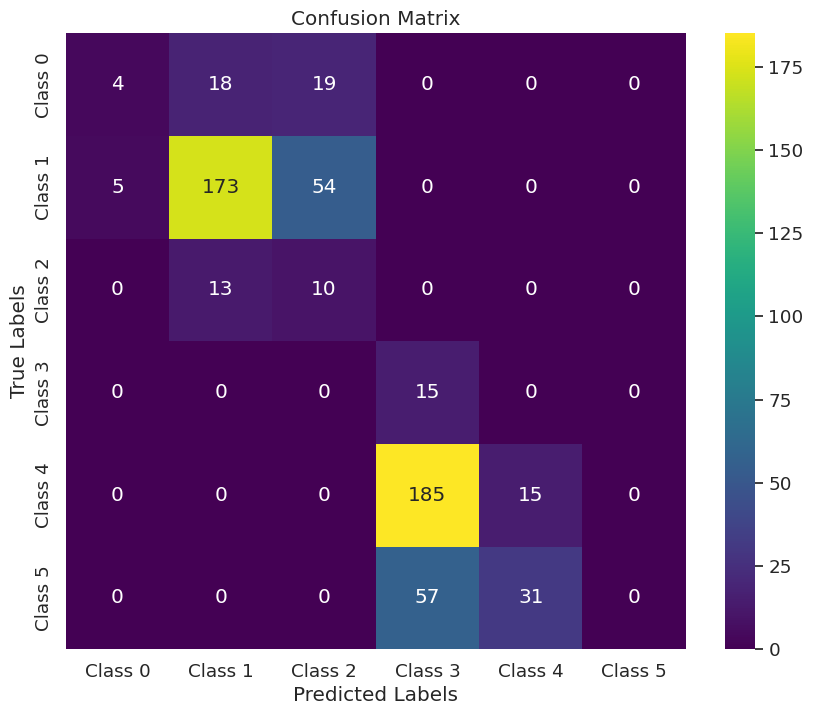

In [84]:
import seaborn as sns
# Define class labels
classes = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(results, annot=True, fmt='d', cmap="viridis", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("CM.png")
plt.show()

In [102]:
dataset1 = 'IP'                                         # 16 classes
ip_x1, ip_y = loadData(dataset1)                              #((512, 217, 204), (512, 217))
ip_x2,pca = applyPCA(ip_x1,numComponents=30)                   # ((512, 217, 20), (512, 217))
ip_X,ip_Y = createImageCubes(ip_x2, ip_y, windowSize=11)   #(111104, 9, 9, 20, 1) (111104,)
print(ip_X.shape,ip_Y.shape)

(21025, 11, 11, 30, 1) (21025,)


In [103]:
# load the original image
X, y = loadData(dataset1)
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 11
numComponents = K
X,pca = applyPCA(X, 30)
X = padWithZeros(X, PATCH_SIZE//2)

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



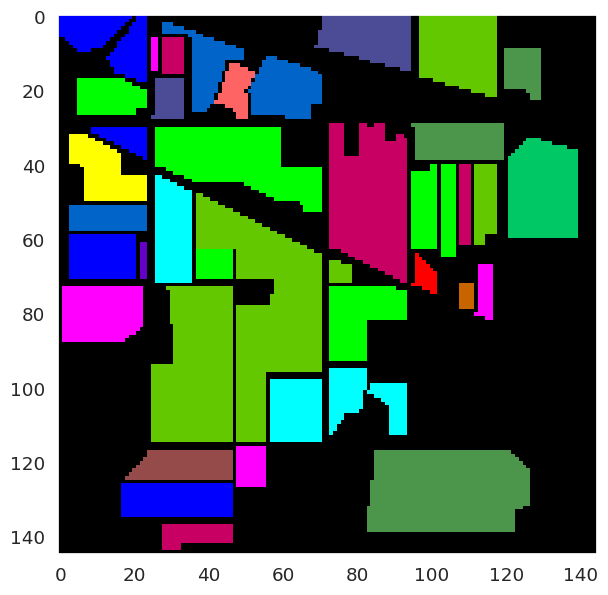

In [108]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))
spectral.save_rgb("gt.png", y, colors=spectral.spy_colors)

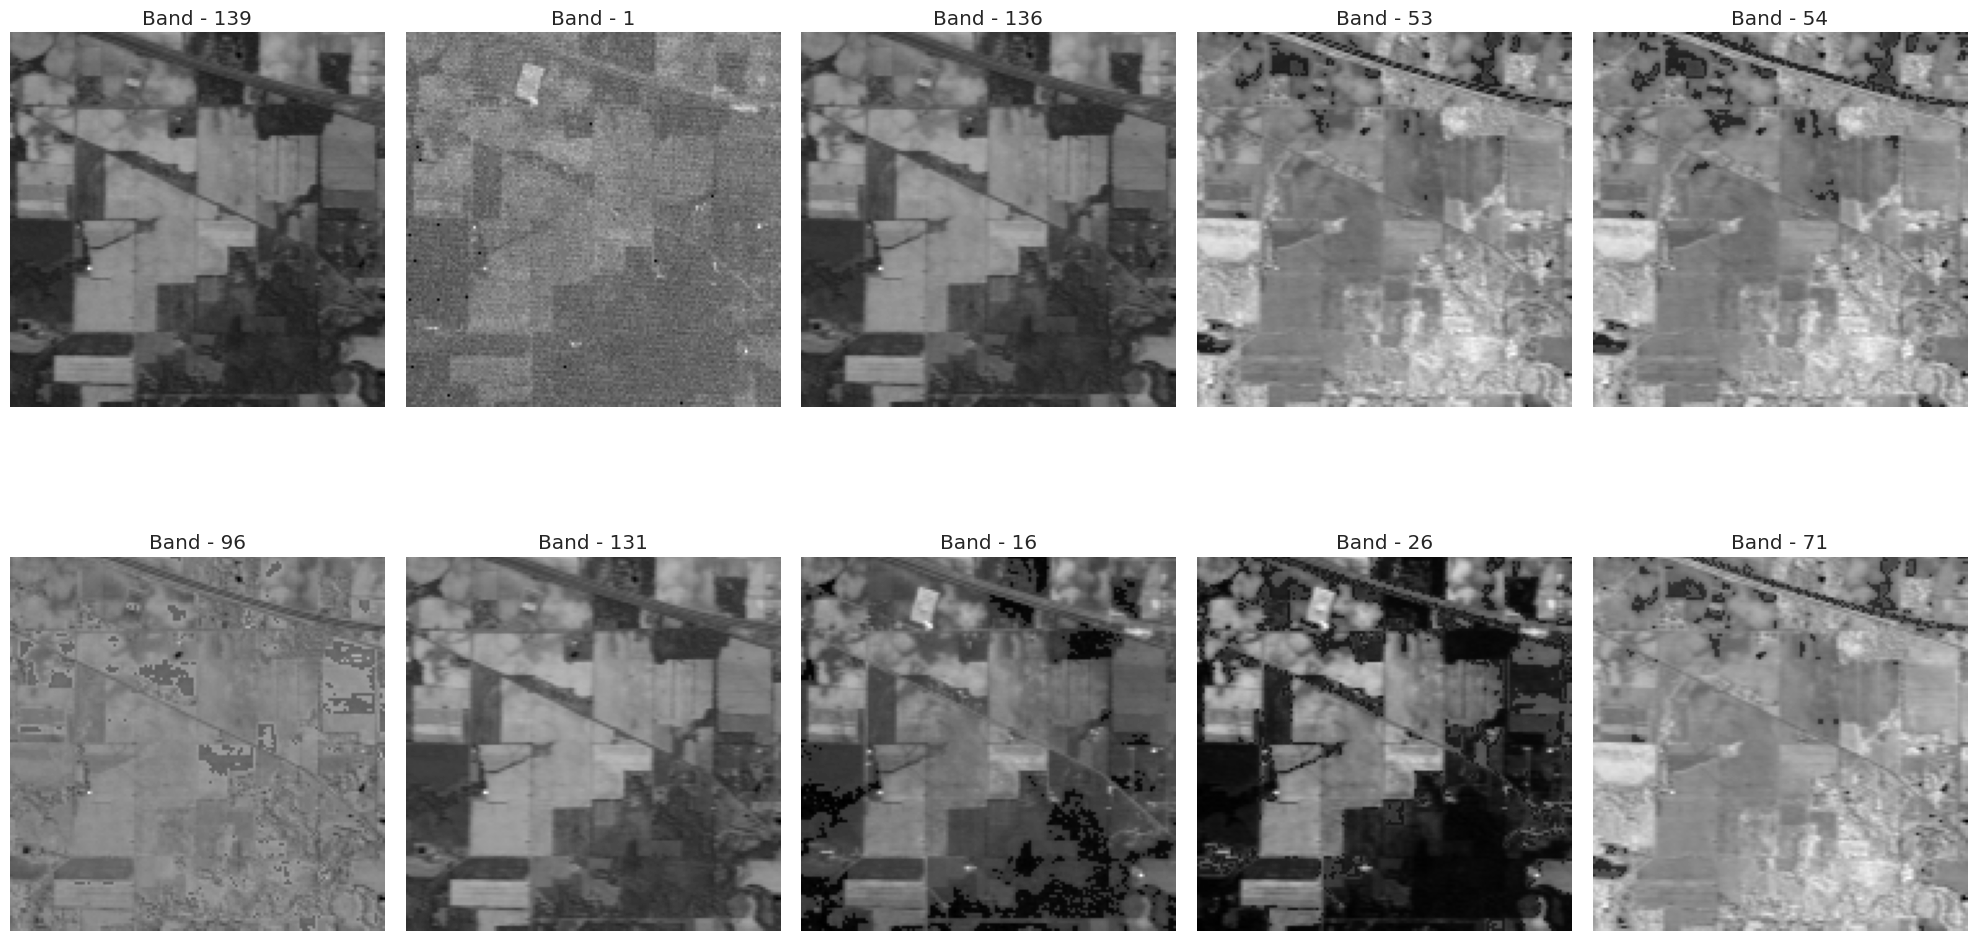

In [105]:
fig = plt.figure(figsize = (20, 12))
ax = fig.subplots(2, 5)

for i in range(2):
    for j in range(5):
        c = np.random.randint(145)
        ax[i][j].imshow(ip_x1[:, :, c], cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].title.set_text(f"Band - {c}")
        c += 1

plt.tight_layout()
plt.savefig('GS.png')
plt.show()

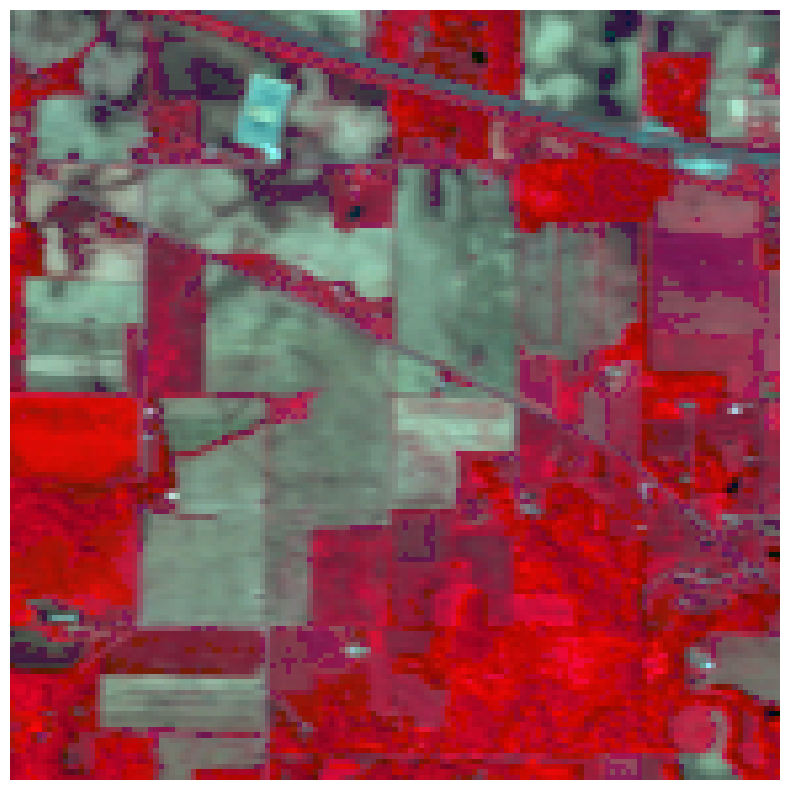

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have loaded your hyperspectral image data into a variable named 'hyperspectral_data'

# Select three spectral bands for RGB composite (adjust these bands according to your data)
red_band = 50
green_band = 27
blue_band = 17

# Extract the selected bands from the hyperspectral data
red_channel = ip_x1[:, :, red_band]
green_channel = ip_x1[:, :, green_band]
blue_channel = ip_x1[:, :, blue_band]

# Normalize the channels to [0, 1] range
red_channel = (red_channel - np.min(red_channel)) / (np.max(red_channel) - np.min(red_channel))
green_channel = (green_channel - np.min(green_channel)) / (np.max(green_channel) - np.min(green_channel))
blue_channel = (blue_channel - np.min(blue_channel)) / (np.max(blue_channel) - np.min(blue_channel))

# Combine the channels into an RGB image
rgb_image = np.stack((red_channel, green_channel, blue_channel), axis=-1)

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.axis('off')

# Save the RGB image without displaying it
plt.savefig("RGB.png", bbox_inches='tight', pad_inches=0)


In [110]:
# This demo needs to be run from the repo folder.
# python demo/fake_gan/run.py
import gradio as gr

with gr.Blocks() as Display:
    gallery = gr.Gallery(value=[
                "/content/GS.png",
                "/content/RGB.png",
                "/content/gt.png",
                "/content/CM.png",

    ],
        label=["Gray scale","RBG","Ground truth","classification map"], show_label=True, elem_id="gallery"
    , columns=[4], rows=[1], object_fit="contain", height="auto")



Display.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c56f1784b0afdad9aa.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
